# Urban POMDP

In [1]:
using POMDPs, StatsBase, POMDPToolbox, DeepRL, Parameters, GridInterpolations
using AutomotiveDrivingModels,AutoViz
using Reel 

In [2]:
include("AutomotivePOMDPs.jl")
using AutomotivePOMDPs

In [4]:
rng = MersenneTwister(1);

In [3]:
params = UrbanParams()
env = UrbanEnv(params=params)
obs_dist = ObstacleDistribution(env)
pomdp = UrbanPOMDP(env=env, obs_dist=obs_dist)

AutomotivePOMDPs.UrbanPOMDP
  env: AutomotivePOMDPs.UrbanEnv
  obs_dist: AutomotivePOMDPs.ObstacleDistribution
  sensor: AutomotiveDrivingModels.LidarSensor
  models: Dict{Int64,AutomotiveDrivingModels.DriverModel}
  ego_type: AutomotiveDrivingModels.VehicleDef
  car_type: AutomotiveDrivingModels.VehicleDef
  ped_type: AutomotiveDrivingModels.VehicleDef
  max_cars: Int64 10
  max_peds: Int64 10
  max_entities: Int64 10
  max_acc: Float64 2.0
  ego_start: Float64 8.0
  ego_goal: AutomotiveDrivingModels.LaneTag
  off_grid: Vec.VecSE2
  ΔT: Float64 0.5
  car_birth: Float64 0.3
  ped_birth: Float64 0.3
  a_noise: Float64 1.0
  v_noise: Float64 1.0
  pos_obs_noise: Float64 0.5
  vel_obs_noise: Float64 0.5
  collision_cost: Float64 -1.0
  action_cost: Float64 0.0
  goal_reward: Float64 1.0
  γ: Float64 0.95


In [6]:
policy = solve(RandomSolver(rng), pomdp)
up = updater(policy);

mutable struct AccelPolicy <: Policy
    problem::UrbanPOMDP
end
policy = AccelPolicy(pomdp)
function POMDPs.action(policy::AccelPolicy, b::Void)
    return actions(policy.problem)[2]
end

In [7]:
hr = HistoryRecorder(rng=rng, max_steps=100)
@time hist = simulate(hr, pomdp, policy, up);

  2.120430 seconds (1.36 M allocations: 73.139 MiB, 1.08% gc time)


In [8]:
duration, fps, render_hist = animate_scenes(hist.state_hist, pomdp.env, overlays = SceneOverlay[IDOverlay()], sim_dt=pomdp.ΔT)
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpHFPww8", 0x0000000000000065, 2.0, nothing)

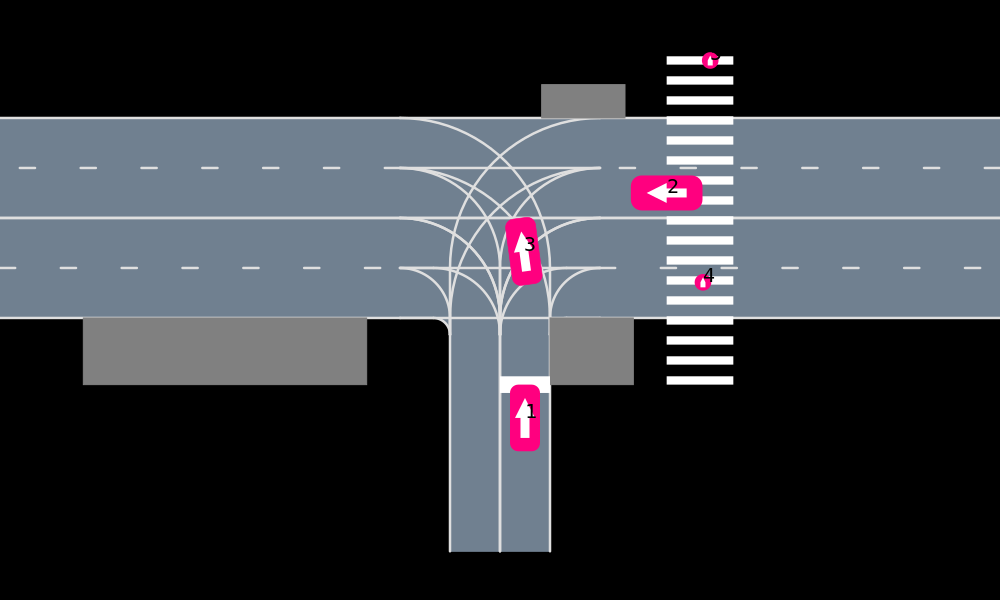

In [10]:
AutoViz.render(initial_state(pomdp, rng), env, [IDOverlay()], cam=FitToContentCamera(0.))

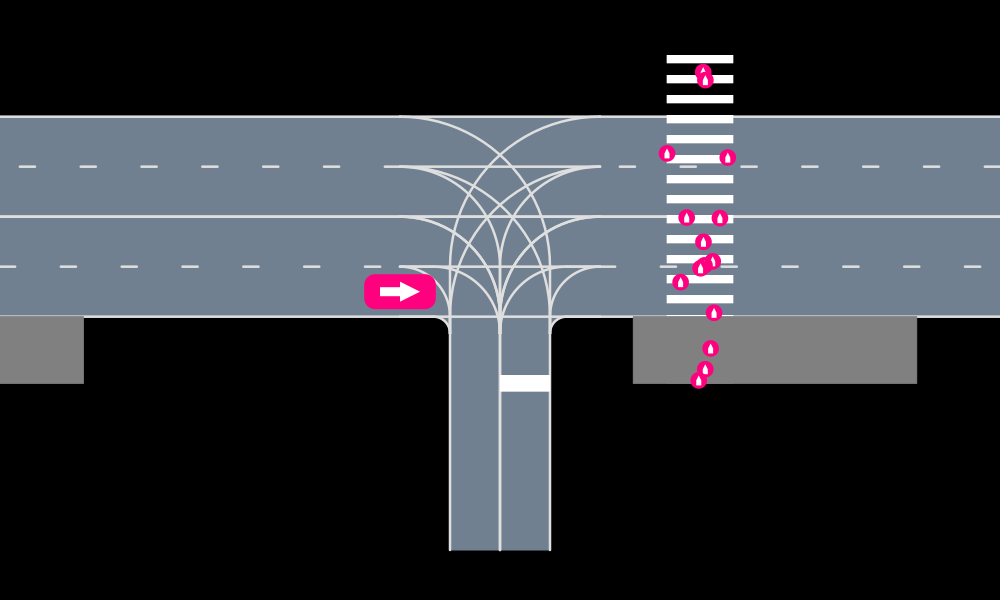

In [13]:
scene = Scene()
models = Dict{Int, DriverModel}()
for i=1:15
    ped = initial_pedestrian(pomdp, scene, rng, true)
    push!(scene, ped)
    models[ped.id] = ConstantPedestrian()
end
# car = initial_car(pomdp, scene, rng)
# collision point 7.0, 4.5
car = Vehicle(VehicleState(Frenet(env.roadway[LaneTag(3,1)], 30.), env.roadway, 6.), VehicleDef(), 1)
push!(scene, car);
AutoViz.render(scene, env, cam=FitToContentCamera(0.))

In [14]:
timestep = 0.5

lane = get_lane(pomdp.env.roadway, car)
route = random_route(rng, pomdp.env.roadway, lane)
intersection_entrances = get_start_lanes(pomdp.env.roadway)
if !(route[1] ∈ intersection_entrances)
    intersection = Lane[]
    intersection_exits = Lane[]
else
    intersection_exits = get_exit_lanes(pomdp.env.roadway)
    intersection=Lane[route[1], route[2]]
end
navigator = RouteFollowingIDM(route=route)
intersection_driver = IntersectionDriver(navigator= navigator,
                                                       intersection=intersection,
                                                       intersection_entrances = intersection_entrances,
                                                       intersection_exits = intersection_exits,
                                                       stop_delta=0.,
                                                       accel_tol=0.)
crosswalk_driver = CrosswalkDriver(navigator = navigator,
                                   crosswalk = pomdp.env.crosswalk,
                                   intersect = get_lane(pomdp.env.roadway, car),
                                   debug=true)
models[car.id] = UrbanDriver(navigator=navigator,
                        intersection_driver=intersection_driver,
                       crosswalk_driver=crosswalk_driver
                                       )

nticks = 50
rec = SceneRecord(nticks+1, timestep)
@time simulate!(rec, scene, pomdp.env.roadway, models, nticks)

buffer ped ttc 0.0
ego ttc -0.3333333333333333
has_crossed ttc-1.5
ped 2 ttc -3.319401881034988
ped 3 ttc -9.545292541198336
ped 4 ttc -14.673213807591488
ped 5 ttc -4.193664518862898
ped 6 ttc -3.078231218119928
ped 7 ttc 1.9807027957369006
ped 8 ttc -0.15506700474667698
ped 9 ttc 1.2467810572728322
ped 10 ttc 1.9677707504361366
ped 11 ttc -3.9522511453967213
ped 12 ttc -9.796513865489688
ped 13 ttc -2.070335963173026
ped 14 ttc -3.29092823520199
ped 15 ttc -1.696840431384068
ped 16 ttc -14.193768781015955
min ped ttc -0.15506700474667698
veh 1 go true stop false clear true
veh 1 go true stop false clear true
veh 1 go true stop false clear true
veh 1 go true stop false clear true
veh 1 go true stop false clear true
veh 1 go true stop false clear true
veh 1 go true stop false clear true
veh 1 go true stop false clear true
veh 1 go true stop false clear true
veh 1 go true stop false clear true
veh 1 go true stop false clear true
veh 1 go true stop false clear true
veh 1 go true stop fal

SceneRecord(nscenes=51)

In [13]:
cam = FitToContentCamera(0.)
duration, fps, render_rec = animate_record(pomdp.env, rec, sim_dt=timestep, overlays = SceneOverlay[IDOverlay()])
film = roll(render_rec, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpibUaxL", 0x0000000000000033, 2.0, nothing)

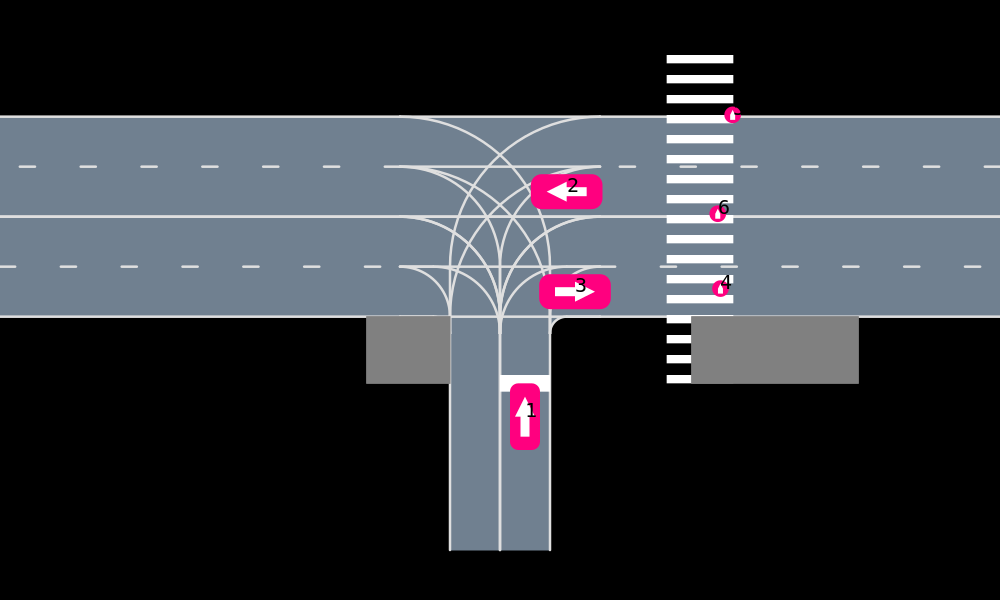

In [56]:
scene = initial_state(pomdp, rng)
AutoViz.render(scene, env, [IDOverlay()], cam=FitToContentCamera(0.))

In [52]:
function lane_to_segment(lane::Lane, roadway::Roadway)
    # only works for straight lanes
    lane_a = get_posG(Frenet(lane, 0.), roadway)
    lane_b = get_posG(Frenet(lane, get_end(lane)), roadway)
    return LineSegment(lane_a, lane_b)
end

function get_conflict_lanes(crosswalk::Lane, roadway::Roadway)
    cw_seg = lane_to_segment(crosswalk, roadway)
    # find lane intersecting with crosswalk 
    conflict_lanes = Lane[]
    lanes = get_lanes(roadway)
    for lane in lanes
        lane_seg = lane_to_segment(lane, roadway)
        if intersects(lane_seg, cw_seg) && !(lane ∈ conflict_lanes)
            push!(conflict_lanes, lane)
        end
    end
    return conflict_lanes
end

# return +1 if going toward, -1 if going away
function direction_from_center(ped::Vehicle, crosswalk::Lane)
    s_ped = ped.state.posF.s
    Δs = get_end(crosswalk)/2 - s_ped
    return sign(Δs*cos(ped.state.posF.ϕ))
end

function is_crossing(ped::Vehicle, crosswalk::Lane, conflict_lanes::Vector{Lane})
    # check if the pedestrian is in the conflict zone
    for lane in conflict_lanes
        ped_f = Frenet(ped.state.posG, lane, roadway)
        if abs(ped_f.t) < lane.width/2
            return true
        end
    end
    # at this point, the pedestrian is not on the road
    # check if she is going to cross or not
    if direction_from_center(ped, crosswalk) > 0.
        return true
    end
    return false
end

is_crossing (generic function with 1 method)

direction_from_center (generic function with 1 method)

In [57]:
# given crosswalk compute the "conflict zone"
crosswalk = env.crosswalk
conflict_lanes = get_conflict_lanes(crosswalk, roadway)

ped = scene[findfirst(scene, 5)]
is_crossing(ped, crosswalk, conflict_lanes)

false

In [31]:
length(conflict_lanes)

4

In [28]:
lane_seg = lane_to_segment(lanes[3], roadway)

Vec.LineSegment(VecE2(12.000, -10.000), VecE2(12.000, 10.000))

In [12]:
methods(get_posG)

# 1 method for generic function "get_posG":
get_posG(frenet::AutomotiveDrivingModels.Frenet, roadway::AutomotiveDrivingModels.Roadway) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/frenet.jl:27

In [9]:
roadway = env.roadway
veh = scene[findfirst(scene, 8)]
lane = get_lane(roadway, veh)

AutomotiveDrivingModels.Lane(LaneTag(25, 1), AutomotiveDrivingModels.CurvePt[CurvePt({12.000, -10.000, 1.571}, 0.000, 0.000, NaN), CurvePt({12.000, 10.000, 1.571}, 20.000, 0.000, NaN)], 4.0, AutomotiveDrivingModels.SpeedLimit(-Inf, Inf), AutomotiveDrivingModels.LaneBoundary(:unknown, :unknown), AutomotiveDrivingModels.LaneBoundary(:unknown, :unknown), AutomotiveDrivingModels.LaneConnection[], AutomotiveDrivingModels.LaneConnection[])

In [27]:
methods(Frenet)

# 10 methods for generic function "(::Type)":
AutomotiveDrivingModels.Frenet(roadind::AutomotiveDrivingModels.RoadIndex, s::Float64, t::Float64, ϕ::Float64) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/frenet.jl:2
AutomotiveDrivingModels.Frenet(roadind::AutomotiveDrivingModels.RoadIndex, roadway::AutomotiveDrivingModels.Roadway; t, ϕ) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/frenet.jl:8
AutomotiveDrivingModels.Frenet(roadproj::AutomotiveDrivingModels.RoadProjection, roadway::AutomotiveDrivingModels.Roadway) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/frenet.jl:13
AutomotiveDrivingModels.Frenet(lane::AutomotiveDrivingModels.Lane, s::Float64) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/frenet.jl:20
AutomotiveDrivingModels.Frenet(lane::AutomotiveDrivingModels.Lane, s::Float64, t::Float64) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/frenet.jl:20
AutomotiveDrivingModels.Frenet(lane::AutomotiveDrivingModels.Lane, s::Float64, t::Float64, ϕ::Float64) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/frenet.jl:20
AutomotiveDrivingModels.Frenet(posG::Vec.VecSE2, roadway::AutomotiveDrivingModels.Roadway) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/frenet.jl:23
AutomotiveDrivingModels.Frenet(posG::Vec.VecSE2, lane::AutomotiveDrivingModels.Lane, roadway::AutomotiveDrivingModels.Roadway) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/frenet.jl:24
AutomotiveDrivingModels.Frenet(roadind, s, t, ϕ) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/frenet.jl:2
(::Type{T})(arg) where T in Base at sysimg.jl:24

In [ ]:
function is_in_lane(veh::Vehicle, lane::Lane, roadway::Roadway)
    pos_g = veh.state.posG
    proj(pos_g, lane)
end

In [12]:
methods(proj)

# 8 methods for generic function "proj":
proj(posG::Vec.VecSE2, curve::Array{AutomotiveDrivingModels.CurvePt,1}) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/roadway/curves.jl:222
proj(posG::Vec.VecSE2, lane::AutomotiveDrivingModels.Lane, roadway::AutomotiveDrivingModels.Roadway; move_along_curves) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/roadway/roadways.jl:367
proj(posG::Vec.VecSE2, seg::AutomotiveDrivingModels.RoadSegment, roadway::AutomotiveDrivingModels.Roadway) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/roadway/roadways.jl:421
proj(posG::Vec.VecSE2, roadway::AutomotiveDrivingModels.Roadway) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/roadway/roadways.jl:444
proj(a::Vec.VecE2, b::Vec.VecE2, ::Type{Float64}) in Vec at /home/boutonm/.julia/v0.6/Vec/src/vecE2.jl:74
proj(a::Vec.VecE2, b::Vec.VecE2, ::Type{Vec.VecE2}) in Vec at /home/boutonm/.julia/v0.6/Vec/src/vecE2.jl:77
proj(a::Vec.VecE3, b::Vec.VecE3, ::Type{Float64}) in Vec at /home/boutonm/.julia/v0.6/Vec/src/vecE3.jl:74
proj(a::Vec.VecE3, b::Vec.VecE3, ::Type{Vec.VecE3}) in Vec at /home/boutonm/.julia/v0.6/Vec/src/vecE3.jl:77

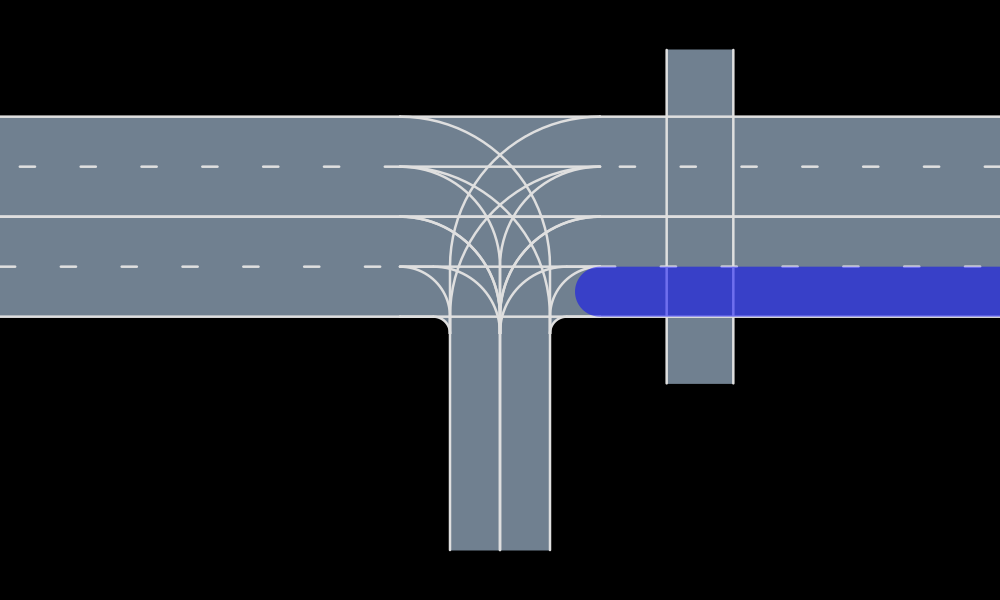

In [43]:
using Interact

scene = Scene()

type LaneOverlay <: SceneOverlay
    lane::Lane
    color::Colorant
end
function AutoViz.render!(rendermodel::RenderModel, overlay::LaneOverlay, scene::Scene, roadway::Roadway)
    render!(rendermodel, overlay.lane, roadway, color_asphalt=overlay.color)
    return rendermodel
end

# @manipulate for i in 1 : length(env.roadway.segments)
#     AutoViz.render(scene, env.roadway, [LaneOverlay(env.roadway[LaneTag(i,1)], RGBA(0.0,0.0,1.0,0.5))], cam=FitToContentCamera(0.))
# end

i=4
AutoViz.render(scene, env.roadway, [LaneOverlay(env.roadway[LaneTag(i,1)], RGBA(0.0,0.0,1.0,0.5))], cam=FitToContentCamera(0.))